In [3]:
%matplotlib inline
import sys 
import xarray as xr
import numpy as np
import os 
import math

coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

filename=['/home/jvalenti/projects/rrg-allen/jvalenti/alpha020190101.nc']

In [4]:
str1 = "Correct cell not found for"
with open("/home/jvalenti/scratch/OParcels_runs/Parcels_alpha/results/stdajulout","r") as movinf:
    listp = movinf.readlines()
lon = []
lat = []
for i in range(0, len(listp)):
    if str1 in listp[i]:
        # do something
        lat.append(float(listp[i].split('(')[1].split(',')[1].split(')')[0]))
        lon.append(float(listp[i].split('(')[1].split(',')[0]))

In [12]:
np.polyfit(coords.nav_lon[2,:],coords.nav_lat[2,:],1)

array([ 0.35157547, 90.26497859])

In [6]:
47*2.84-256

-122.52000000000001

In [22]:
-123.5*0.35112579 + 90.19978543

46.83575036500001

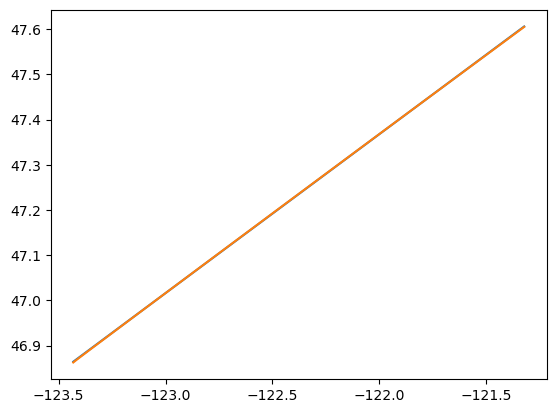

In [33]:
plt.plot(coords.nav_lon[1,:],coords.nav_lon[1,:]*0.35135207 + 90.23255615)
plt.plot(coords.nav_lon[1,:],coords.nav_lat[1,:])
#

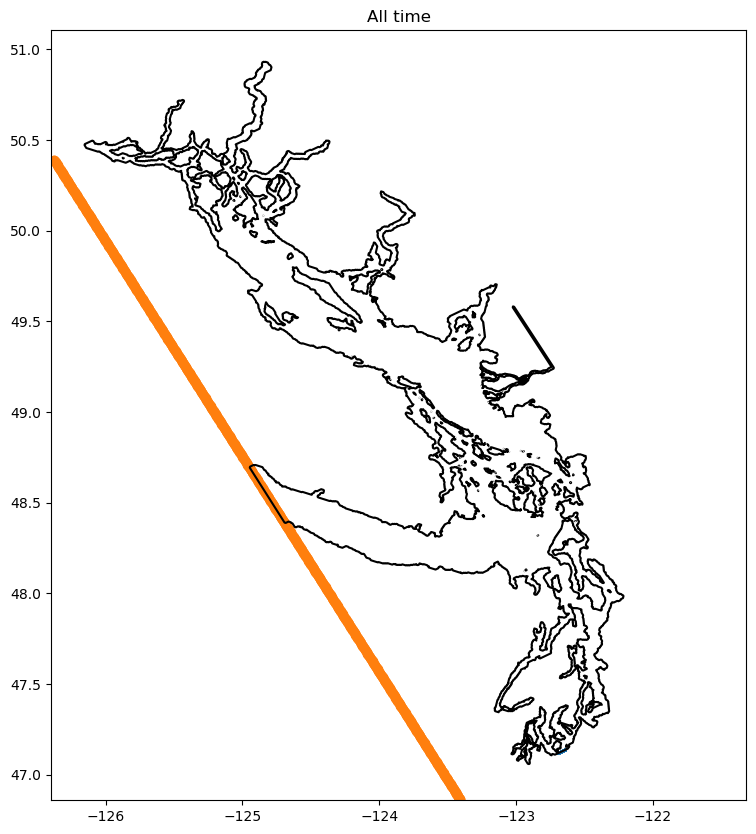

In [37]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(16, 10))
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/np.sin(np.deg2rad(49)))
ax.set_title('All time')
#plt.xlim(-122.685963-0.125,-122.685963+0.125)
#plt.ylim(47.123597-0.125,47.123597+0.125)
plt.scatter(lon,lat,s=1)
plt.scatter(coords.nav_lat[:,1]* -0.84122918 -83.98618424, coords.nav_lat[:,1])

In [2]:
u = xr.open_dataset('/home/jvalenti/scratch/OParcels_runs/NEMO/SalishSea_1h_20190401_20190401_grid_T.nc')

In [3]:
u.sigma_theta[0,0,0,140].values

array(0., dtype=float32)

In [4]:
mask.totaldepth[0,140].values

array(0., dtype=float32)

In [5]:
def latT(lat):
    return np.cos(lat*(math.pi/180))

def count_inside_grid_cell(center_x, center_y, cell_width, cell_height, x,y):
    deg2met = 111319.5
    cell_width = cell_width/(deg2met*latT(center_y))
    cell_height = cell_height/deg2met
    min_x = np.array(center_x - cell_width / 2)
    max_x = np.array(center_x + cell_width / 2)
    min_y = np.array(center_y - cell_height / 2)
    max_y = np.array(center_y + cell_height / 2)
    inside_mask = np.logical_and.reduce([
        min_x[:, np.newaxis] <= x,
        x <= max_x[:, np.newaxis],
        min_y[:, np.newaxis] <= y,
        y <= max_y[:, np.newaxis]
    ])
    c = np.sum(inside_mask,axis=1)
    return c



ds = xr.open_dataset(filename[0],decode_times=False)
MFc = 5e6
zlevels = [0,5,10]
DS=ds.to_dataframe()
#DS = DS[DS.z < 800]
DS = DS[DS.status==1]
lat = coords.nav_lat
lon = coords.nav_lon
td = mask.totaldepth
cell_width = coords.e1t[0,:,:]
cell_height = coords.e2t[0,:,:]
x = np.array(DS.lon)
y = np.array(DS.lat)
z = np.array(DS.z)

MemoryError: Unable to allocate 713. MiB for an array with shape (6, 31161696) and data type float32

In [ ]:
(np.log(0.5)/np.log(1-0.05))*5

67.56703666982438

Text(0, 0.5, 'half-life (days)')

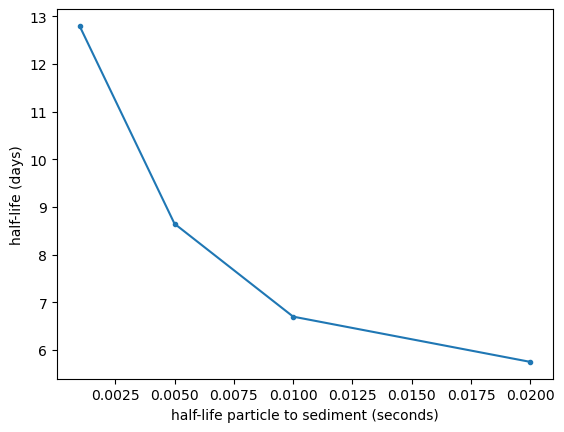

In [13]:
import matplotlib.pyplot as plt
x = [0.001,0.005,0.01,0.02]
x2  = [345,67.5,33,15]
y = [12.8,8.65,6.7,5.75]
plt.plot(x,y,'.-')
plt.xlabel('half-life particle to sediment (seconds)')
plt.ylabel('half-life (days)')


In [ ]:
conc = np.zeros((len(zlevels),coords.nav_lon.shape[0],coords.nav_lon.shape[1]))
for k in range(len(zlevels)):
    print(f'{k} level starting.')  
    for j in range(coords.nav_lon.shape[0]):
        zmin = int(zlevels[k])
        try:
            zmax = int(zlevels[k+1])
        except IndexError:
            zmax = 800
        X = x[np.logical_and(z >= zmin, z < zmax)]
        Y = y[np.logical_and(z >= zmin, z < zmax)]
        if zmax==800:
            BOXvolume = np.array((cell_width[j,:]* cell_height[j,:]*(td[j,:]-zmin)))
        else:
            BOXvolume = np.array((cell_width[j,:]* cell_height[j,:]*(zmax-zmin)))
        conc[k,j,:]+= count_inside_grid_cell(lon[j,:], lat[j,:], cell_width[j,:], cell_height[j,:],X,Y)*MFc/BOXvolume

0 level starting.


NameError: name 'z' is not defined

In [16]:
str1 = "Correct cell not found for"
with open("/home/jvalenti/scratch/OParcels_runs/Parcels_alpha/results/stdaagoout","r") as movinf:
    listp = movinf.readlines()
lon = []
lat = []
for i in range(0, len(listp)):
    if str1 in listp[i]:
        # do something
        lat.append(listp[i].split('(')[1].split(',')[1].split(')')[0])
        lon.append(listp[i].split('(')[1].split(',')[0])

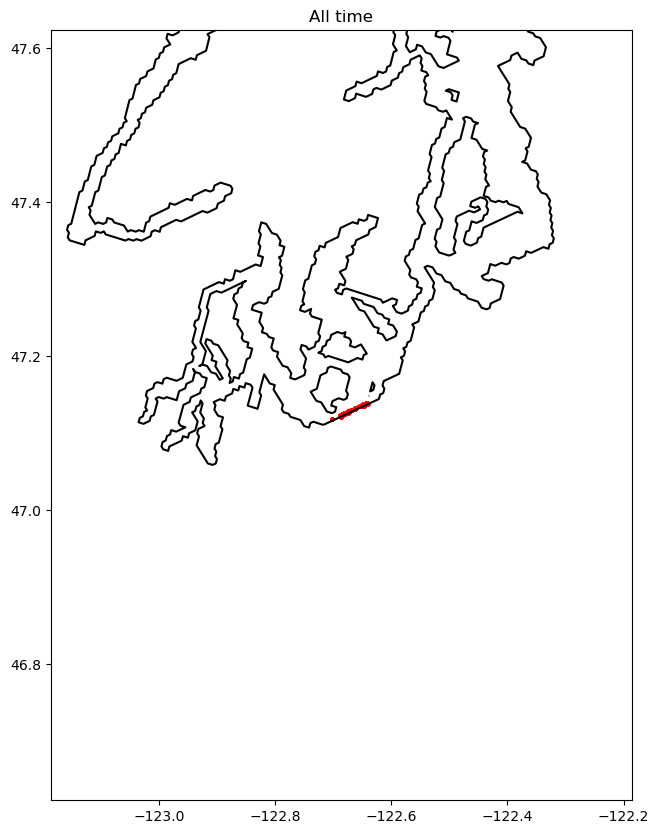

In [8]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean

cm = cmocean.cm.dense
#conc = np.load('/ocean/jvalenti/MOAD/concentration_31days.npy')
##ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
fig, ax = plt.subplots(1,1,figsize=(16, 10))
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
#aa = ax.contourf(coords.nav_lon, coords.nav_lat,mask.umask[0,0,:,:],levels = np.linspace(0,50,12), extend='both')
#aa.cmap.set_over('orange')
#aa.cmap.set_under('white')
#plt.colorbar(aa)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
ax.set_title('All time')
plt.xlim(-122.685963-0.5,-122.685963+0.5)
plt.ylim(47.123597-0.5,47.123597+0.5)
plt.scatter(lon,lat,s=2,c='r')